In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('F:\\pythonproject\\Tensor\\Chunk_v2\\')
import Chunk
import seaborn as sns
import matplotlib.pyplot as plt

CellPhoneDB

In [6]:
cp_lri = pd.read_csv('F:\\pythonproject\\Tensor\\Chunk_v2\\result\\benchmark\\cellphone\\relevant_interactions.txt',sep='\t')

In [18]:
gene_list = cp_lri['gene_b'].dropna().tolist() + cp_lri['gene_a'].dropna().tolist()
gene_list = list(set(gene_list))

In [21]:
pd.DataFrame(gene_list,columns=['gene']).to_csv('F:\\pythonproject\\Tensor\\Chunk_v2\\result\\benchmark\\GSVA/cellphoneDB_lrgene.csv')

Multinichenet

In [22]:
mu_lri = pd.read_csv('F:\\pythonproject\\Tensor\\Chunk_v2\\result\\benchmark\\multinichenet\\multinichenet_lri.csv')

In [24]:
gene_list = mu_lri['ligand'].dropna().tolist() + mu_lri['receptor'].dropna().tolist()
gene_list = list(set(gene_list))

In [27]:
pd.DataFrame(gene_list,columns=['gene']).to_csv('F:\\pythonproject\\Tensor\\Chunk_v2\\result\\benchmark\\GSVA/Multinichenet_lrgene.csv')

Cellchat

In [29]:
cc_lri = pd.read_csv('F:\\pythonproject\\Tensor\\Chunk_v2\\result\\benchmark\\cellchat\\cellchat_lri.csv')

In [40]:
ga=[]
for i in cc_lri['x'].tolist():
    ga.append(i.split('_')[0])
    ga.append(i.split('_')[1])
gene_list=list(set(ga))

In [42]:
pd.DataFrame(gene_list,columns=['gene']).to_csv('F:\\pythonproject\\Tensor\\Chunk_v2\\result\\benchmark\\GSVA/cellchat_lrgene.csv')

tensor_cell2cell

In [47]:
tc_lri = pd.read_csv('F:\\pythonproject\\Tensor\\Chunk_v2\\result\\benchmark\\tensorc2c\\tensorc2c_lri.csv',index_col=0)

In [49]:
ga=[]
for i in tc_lri['Column1'].tolist():
    ga.append(i.split('^')[0])
    ga.append(i.split('^')[1])
gene_list=list(set(ga))

In [ ]:
pd.DataFrame(gene_list,columns=['gene']).to_csv('F:\\pythonproject\\Tensor\\Chunk_v2\\result\\benchmark\\GSVA/tensorc2c_lrgene.csv')

scriabin

In [2]:
scr_lri = pd.read_csv('F:\\pythonproject\\Tensor\\Chunk_v2\\result\\benchmark\\scriabin\\scriabin_lri.csv')

In [3]:
ga=[]
for i in scr_lri['lr_pair'].tolist():
    ga.append(i.split('=')[0])
    ga.append(i.split('=')[1])
gene_list=list(set(ga))

In [4]:
pd.DataFrame(gene_list,columns=['gene']).to_csv('F:\\pythonproject\\Tensor\\Chunk_v2\\result\\benchmark\\GSVA/scriabin_lrgene.csv')

GSE

In [59]:
n = pd.read_csv('F:\\pythonproject\\Tensor\\Chunk_v2\\result\\benchmark\\GSVA\\GSE152418_p20047_Study1_RawCounts.txt.gz',index_col=0,sep='\t')

In [63]:
import mygene
mg = mygene.MyGeneInfo()

ensembl_ids = n.index.tolist()  
results = mg.querymany(ensembl_ids, scopes='ensembl.gene', fields='symbol', species='human')
id_to_name = {result['query']: result.get('symbol', 'N/A') for result in results}
n.index = n.index.map(id_to_name)

Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed
35 input query terms found dup hits:	[('ENSG00000228044', 2), ('ENSG00000226506', 2), ('ENSG00000261600', 2), ('ENSG00000234162', 2), ('E
1300 input query terms found no hit:	['ENSG00000238009', 'ENSG00000288531', 'ENSG00000230699', 'ENSG00000241180', 'ENSG00000236948', 'ENS


In [72]:
label=[]
for i in n.columns.tolist():
    if 'nC' in i:
        label.append('COVID')
    else:
        label.append('nonCOVID')
n.columns=label
n = n[n.index != 'N/A']
n = n[(n > 1).any(axis=1)]
n= n[~n.index.duplicated(keep='first')]

In [208]:
n.to_csv('F:\\pythonproject\\Tensor\\Chunk_v2\\result\\benchmark\\GSVA/GSE152418_count.csv')

In [204]:
n = pd.read_csv('F:\\pythonproject\\Tensor\\Chunk_v2\\result\\benchmark\\GSVA/GSE152418_logtpm.csv',index_col=0)

In [144]:
def counts2FPKM(counts, genelen):
    genelen = pd.read_csv(genelen, sep=',')
    genelen['TranscriptLength'] = genelen['Transcript end (bp)'] - genelen['Transcript start (bp)']
    genelen = genelen[['Gene name', 'TranscriptLength']]
    genelen = genelen.groupby('Gene name').max()

    inter = counts.columns.intersection(genelen.index)
    if len(inter) == 0:
        raise ValueError("No overlapping genes found between counts and gene length data.")

    samplename = counts.index
    counts = counts[inter].values
    genelen = genelen.loc[inter].T.values

    totalreads = counts.sum(axis=1)
    fpkm = counts * 1e9 / (genelen * totalreads.reshape(-1, 1))
    fpkm_df = pd.DataFrame(fpkm, columns=inter, index=samplename)
    
    return fpkm_df
    
def FPKM2TPM(fpkm):
    genename = fpkm.columns
    samplename = fpkm.index
    fpkm = fpkm.values
    total = fpkm.sum(axis=1).reshape(-1, 1)
    fpkm = fpkm * 1e6 / total
    tpm = pd.DataFrame(fpkm, columns=genename, index=samplename)
    return tpm



def counts2TPM(counts, genelen):
    fpkm = counts2FPKM(counts, genelen)
    tpm = FPKM2TPM(fpkm)
    return tpm

def counts2log1tpm(counts, genelen_file=None):
    """
    Convert the count matrix of adata to TPM format (in sparse matrix mode) and perform log-normalization.

    Parameters:
    counts:row-sample,columns-gene
    genelen_file (str): Path to the gene length file. If None, use the default file in the package.

    Returns:
    adata (AnnData): Converted AnnData object, with adata.X as a sparse matrix.
    """

    tpm = counts2TPM(counts, genelen_file)

    tpm = tpm.map(lambda x: np.log2(x + 1))

    return tpm

In [145]:
m= counts2log1tpm(n.T,'F:\\pythonproject\\Tensor\\Chunk_v2\\Chunk\\data\\GeneLength.txt')

In [149]:
m.T.to_csv('F:\\pythonproject\\Tensor\\Chunk_v2\\result\\benchmark\\GSVA/GSE152418_logtpm.csv')

Visization

ssGSEA

In [10]:
import gseapy as gp
n = pd.read_csv('F:\\pythonproject\\Tensor\\Chunk_v2\\result\\benchmark\\GSVA/GSE152418_logtpm.csv',index_col=0)
#lr_genes = pd.read_csv('F:\\pythonproject\\Tensor\\Chunk_v2\\result\\benchmark\\GSVA/Chunk_lrgene.csv',index_col=0)['gene'].tolist()
#lr_genes = pd.read_csv('F:\\pythonproject\\Tensor\\Chunk_v2\\result\\benchmark\\GSVA/cellphoneDB_lrgene.csv',index_col=0)['gene'].tolist()
#lr_genes = pd.read_csv('F:\\pythonproject\\Tensor\\Chunk_v2\\result\\benchmark\\GSVA/cellchat_lrgene.csv',index_col=0)['gene'].tolist()
#lr_genes = pd.read_csv('F:\\pythonproject\\Tensor\\Chunk_v2\\result\\benchmark\\GSVA/tensorc2c_lrgene.csv',index_col=0)['gene'].tolist()
#lr_genes = pd.read_csv('F:\\pythonproject\\Tensor\\Chunk_v2\\result\\benchmark\\GSVA/Multinichenet_lrgene.csv',index_col=0)['gene'].tolist()
lr_genes = pd.read_csv('F:\\pythonproject\\Tensor\\Chunk_v2\\result\\benchmark\\GSVA/scriabin_lrgene.csv',index_col=0)['gene'].tolist()
gene_list = lr_genes
gene_set = {'COVID relevant L-R gene':gene_list}
ssgsea_results = gp.ssgsea(
    data=n,                                 
    gene_sets=gene_set,                
    outdir=None,                              
    sample_norm_method='rank',                 
    weight=0,
    min_size=5,                                
    max_size=1000,                            
    threads=4             
)

es_matrix = ssgsea_results.res2d
es_matrix.index = es_matrix['Name']
es_matrix = es_matrix.drop('Name',axis=1)
es_matrix['sample']=es_matrix.index
es_matrix['Group'] = es_matrix['sample'].apply(lambda x: 'nonCOVID' if 'nonCOVID' in x else 'COVID')

C:\Users\Admin\AppData\Local\Temp\ipykernel_29612\1885104309.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=es_matrix, x='Group', y='NES', palette='Set2')


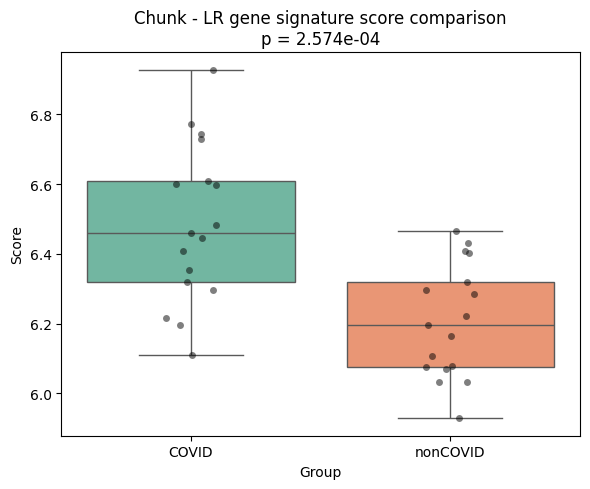

In [8]:
#Chunk
plt.figure(figsize=(6, 5))
sns.boxplot(data=es_matrix, x='Group', y='NES', palette='Set2')
sns.stripplot(data=es_matrix, x='Group', y='NES', color='black', alpha=0.5)

from scipy.stats import ttest_ind

group1 = es_matrix[es_matrix['Group'] == 'nonCOVID']['NES']
group2 = es_matrix[es_matrix['Group'] == 'COVID']['NES']
t_stat, p_val = ttest_ind(group1.tolist(), group2.tolist())
plt.ylabel('Score', fontsize=10)
plt.title(f'Chunk - LR gene signature score comparison\np = {p_val:.3e}')
plt.tight_layout()
#plt.savefig('F:\\pythonproject\\Tensor\\Chunk_v2\\result\\benchmark\\GSVA\\ssGSEA_pic\\Chunk_ssgsea.png')
plt.show()

In [9]:
es_matrix

,Term,ES,NES,sample,Group
Name,,,,,
COVID.9,COVID relevant L-R gene,10254.928395,6.928586,COVID.9,COVID
COVID.7,COVID relevant L-R gene,10024.423074,6.772849,COVID.7,COVID
COVID.13,COVID relevant L-R gene,9981.073618,6.74356,COVID.13,COVID
COVID.12,COVID relevant L-R gene,9961.626297,6.730421,COVID.12,COVID
COVID.3,COVID relevant L-R gene,9781.000581,6.608384,COVID.3,COVID
COVID.14,COVID relevant L-R gene,9768.97795,6.600261,COVID.14,COVID
COVID.6,COVID relevant L-R gene,9765.757603,6.598085,COVID.6,COVID
COVID.5,COVID relevant L-R gene,9594.864493,6.482624,COVID.5,COVID
nonCOVID.10,COVID relevant L-R gene,9571.141266,6.466596,nonCOVID.10,nonCOVID


C:\Users\Admin\AppData\Local\Temp\ipykernel_29612\395122798.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=es_matrix.loc[n.columns], x='Group', y='NES', palette='Set2')


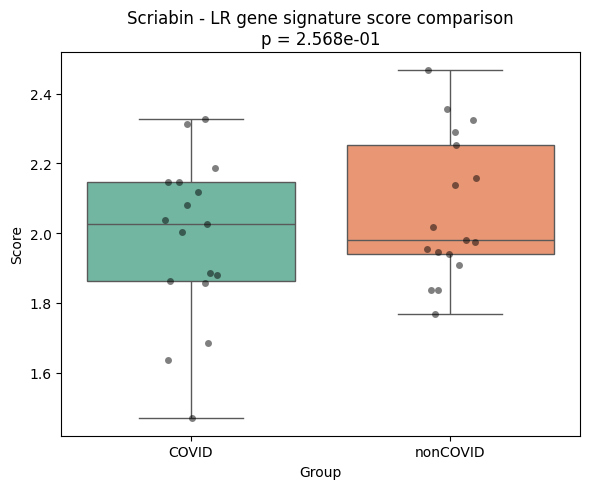

In [21]:
#Scriabin
plt.figure(figsize=(6, 5))
sns.boxplot(data=es_matrix.loc[n.columns], x='Group', y='NES', palette='Set2')
sns.stripplot(data=es_matrix.loc[n.columns], x='Group', y='NES', color='black', alpha=0.5)

from scipy.stats import ttest_ind

group1 = es_matrix[es_matrix['Group'] == 'nonCOVID']['NES']
group2 = es_matrix[es_matrix['Group'] == 'COVID']['NES']
t_stat, p_val = ttest_ind(group1.tolist(), group2.tolist())
plt.ylabel('Score', fontsize=10)
plt.title(f'Scriabin - LR gene signature score comparison\np = {p_val:.3e}')
plt.tight_layout()
#plt.savefig('F:\\pythonproject\\Tensor\\Chunk_v2\\result\\benchmark\\GSVA\\ssGSEA_pic\\scriabin_ssgsea.png')
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_27180\2356069047.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=es_matrix, x='Group', y='NES', palette='Set2')


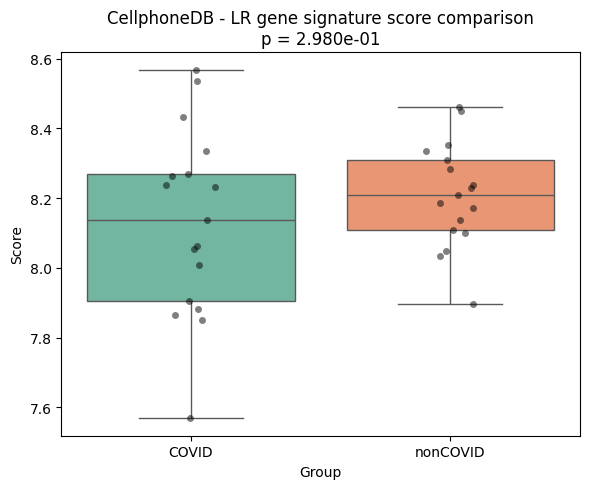

In [252]:
#Cellphonedb
plt.figure(figsize=(6, 5))
sns.boxplot(data=es_matrix, x='Group', y='NES', palette='Set2')
sns.stripplot(data=es_matrix, x='Group', y='NES', color='black', alpha=0.5)

from scipy.stats import ttest_ind

group1 = es_matrix[es_matrix['Group'] == 'nonCOVID']['NES']
group2 = es_matrix[es_matrix['Group'] == 'COVID']['NES']
t_stat, p_val = ttest_ind(group1.tolist(), group2.tolist())

plt.ylabel('Score', fontsize=10)
plt.title(f'CellphoneDB - LR gene signature score comparison\np = {p_val:.3e}')
plt.tight_layout()
#plt.savefig('F:\\pythonproject\\Tensor\\Chunk_v2\\result\\benchmark\\GSVA\\ssGSEA_pic\\cellphonedb_ssgsea.png')
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_27180\1888333916.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=es_matrix, x='Group', y='NES', palette='Set2')


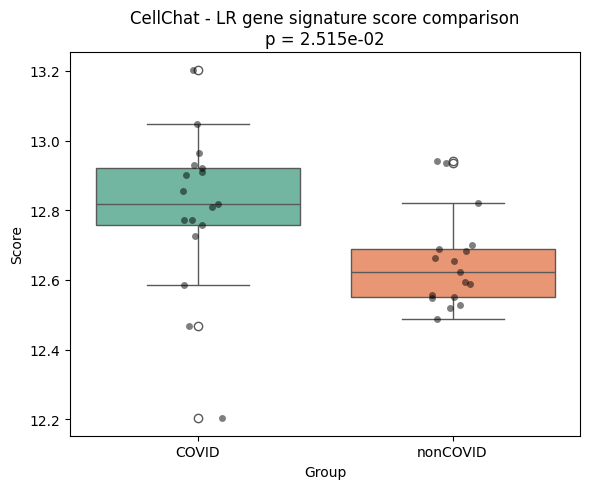

In [254]:
#Cellchat
plt.figure(figsize=(6, 5))
sns.boxplot(data=es_matrix, x='Group', y='NES', palette='Set2')
sns.stripplot(data=es_matrix, x='Group', y='NES', color='black', alpha=0.5)

from scipy.stats import ttest_ind

group1 = es_matrix[es_matrix['Group'] == 'nonCOVID']['NES']
group2 = es_matrix[es_matrix['Group'] == 'COVID']['NES']
t_stat, p_val = ttest_ind(group1.tolist(), group2.tolist())

plt.ylabel('Score', fontsize=10)
plt.title(f'CellChat - LR gene signature score comparison\np = {p_val:.3e}')
plt.tight_layout()
#plt.savefig('F:\\pythonproject\\Tensor\\Chunk_v2\\result\\benchmark\\GSVA\\ssGSEA_pic\\cellchat_ssgsea.png')
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_27180\2422516002.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=es_matrix, x='Group', y='NES', palette='Set2')


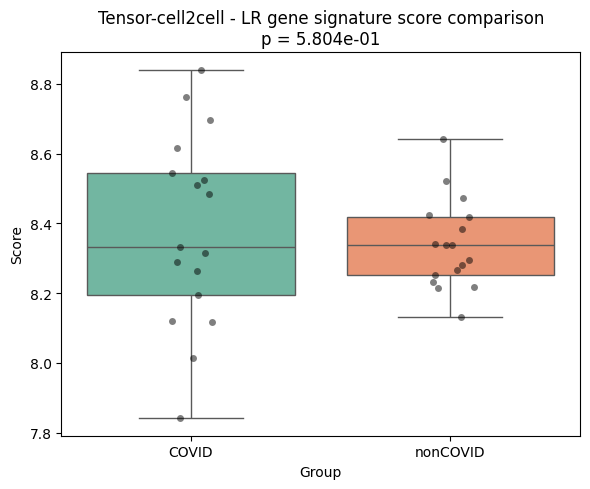

In [256]:
#Tensor-c2c
plt.figure(figsize=(6, 5))
sns.boxplot(data=es_matrix, x='Group', y='NES', palette='Set2')
sns.stripplot(data=es_matrix, x='Group', y='NES', color='black', alpha=0.5)

from scipy.stats import ttest_ind

group1 = es_matrix[es_matrix['Group'] == 'nonCOVID']['NES']
group2 = es_matrix[es_matrix['Group'] == 'COVID']['NES']
t_stat, p_val = ttest_ind(group1.tolist(), group2.tolist())

plt.ylabel('Score', fontsize=10)
plt.title(f'Tensor-cell2cell - LR gene signature score comparison\np = {p_val:.3e}')
plt.tight_layout()
#plt.savefig('F:\\pythonproject\\Tensor\\Chunk_v2\\result\\benchmark\\GSVA\\ssGSEA_pic\\tensorc2c_ssgsea.png')
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_27180\1068516463.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=es_matrix, x='Group', y='NES', palette='Set2')


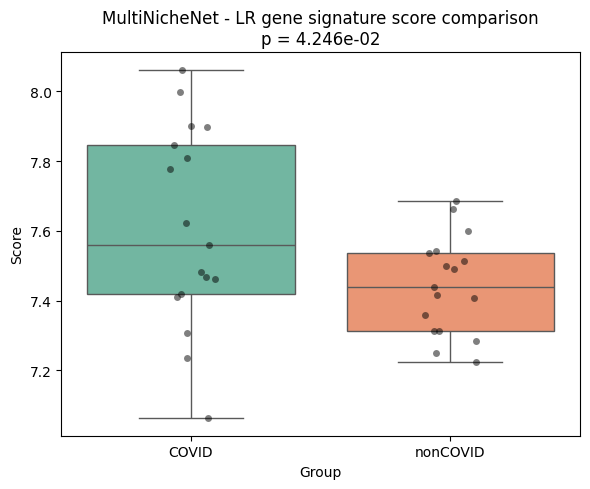

In [258]:
#MultiNiche
plt.figure(figsize=(6, 5))
sns.boxplot(data=es_matrix, x='Group', y='NES', palette='Set2')
sns.stripplot(data=es_matrix, x='Group', y='NES', color='black', alpha=0.5)

from scipy.stats import ttest_ind

group1 = es_matrix[es_matrix['Group'] == 'nonCOVID']['NES']
group2 = es_matrix[es_matrix['Group'] == 'COVID']['NES']
t_stat, p_val = ttest_ind(group1.tolist(), group2.tolist())

plt.ylabel('Score', fontsize=10)
plt.title(f'MultiNicheNet - LR gene signature score comparison\np = {p_val:.3e}')
plt.tight_layout()
#plt.savefig('F:\\pythonproject\\Tensor\\Chunk_v2\\result\\benchmark\\GSVA\\ssGSEA_pic\\multinichenet_ssgsea.png')
plt.show()